This notebook is desgined to read in data from OpenML-CC18 benchmark suite. There are functions like scree_2 which creates a scree plot with with the dimension selection estimations shown. scree_basic produces the same plot but without the estimations shown. 

In [1]:
import numpy as np
import openml
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
# from proglearn.forest import UncertaintyForest

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot

from sklearn.utils.extmath import svd_flip
from sklearn.decomposition._pca import _infer_dimension
from scipy import linalg

import warnings
warnings.filterwarnings('ignore')
np.random.seed(8889)
%matplotlib inline

In [3]:
from sklearn.utils.extmath import svd_flip
from sklearn.decomposition._pca import _infer_dimension
from scipy import linalg

def minka(X):
    
    n_components = 'mle'
    n_samples = X.shape[0]
    U, S, Vt = linalg.svd(X, full_matrices=False)
    # flip eigenvectors' sign to enforce deterministic output
    U, Vt = svd_flip(U, Vt)

    components_ = Vt

    # Get variance explained by singular values
    explained_variance_ = (S ** 2) / (n_samples - 1)
    total_var = explained_variance_.sum()
    explained_variance_ratio_ = explained_variance_ / total_var
    singular_values_ = S.copy()  # Store the singular values.
    # Postprocess the number of components required
    if n_components == 'mle':
        #print(explained_variance_.shape[0])
        #print(n_samples)
        n_components = \
            _infer_dimension(explained_variance_, n_samples)
    return n_components

In [4]:
from graspologic.embed import select_dimension

In [5]:
benchmark_suite = openml.study.get_suite('OpenML-CC18') # obtain the benchmark suite

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ya_pca.linalg_utils import svd_wrapper
from ya_pca.viz import scree_plot

#Make a random array and then make it positive-definite
# true -- where we expect value to be 
# d1 -- ZG no hack elbow 1
# d2 -- ZG no hack elbow 2
# d3 -- minka 
# d4 -- ZG  hack elbow 1
# d5 -- ZG  hack elbow 2

def scree_2(A, d1, d2, d3, d4, d5, task_id):
    U, svals, V = svd_wrapper(A)
    plt.figure(figsize=(8, 8))
    colors = sns.color_palette()
    scree_plot(svals, color = colors[4])
    axes = plt.gca()
    axes.set_xlim([.5, len(svals) + 1])
    axes.set_ylim([min(svals) - 2 ,max(svals) + 2])
    plt.title('Scree Plot of ' + str(task_id) + ', Dimensions: '+ str(A.shape[0]) + "," + str(A.shape[1]))
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    ds = [int(np.median(d1)), int(np.median(d2)), int(np.median(d3)), int(np.median(d4)), int(np.median(d5))]
    locs = []
    added = set()
    for i in range(len(ds)):
        if ds[i] in added:  
            rec_ind = 0
            for j in range(0, i):
                if ds[j] == ds[i]:
                    rec_ind = j
            locs.append(locs[rec_ind] + .1)
        else:
            locs.append(ds[i])
        added.add(ds[i])
    plt.axvline(locs[0], label='ZG(1):{}'.format(ds[0]), color=colors[0], ls='--', zorder =  1)
    plt.axvline(locs[1], label='ZG(2):{}'.format(ds[1]), color=colors[0], ls=':', zorder =  1)
    plt.axvline(locs[2], label='minka:{}'.format(ds[2]), color=colors[1], ls='--', zorder =  1)
    plt.axvline(locs[3], label='ZG_hack(1):{}'.format(ds[3]), color= colors[2], ls='--', zorder =  1)
    plt.axvline(locs[4], label='ZG_hack(2):{}'.format(ds[4]), color=colors[2], ls=':', zorder =  1)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left',)
    
    

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ya_pca.linalg_utils import svd_wrapper
from ya_pca.viz import scree_plot
import random

#Make a random array and then make it positive-definite
# true -- where we expect value to be 
# d1 -- ZG no hack elbow 1
# d2 -- ZG no hack elbow 2
# d3 -- minka 
# d4 -- ZG  hack elbow 1
# d5 -- ZG  hack elbow 2

def scree_basic(A, task_id):
    U, svals, V = svd_wrapper(A)
    plt.figure(figsize=(8, 8))
    colors = sns.color_palette()
    scree_plot(svals, color = colors[5])
    #set_xlim(bottom=0, top=max(svals))
    #plt.xlim(0)   
    axes = plt.gca()
    axes.set_xlim([.5, len(svals) + 1])
    axes.set_ylim([min(svals) - 2 ,max(svals) + 2])
    
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    plt.title('Scree Plot of ' + str(task_id) + ', Dimensions: '+ str(A.shape[0]) + "," + str(A.shape[1]))

In [ ]:
all_data = []
for i, task_id in enumerate(benchmark_suite.tasks):  # iterate over all tasks
    task = openml.tasks.get_task(task_id)  # download the OpenML task
    A, y = task.get_X_and_y()  # get the data
    A = np.nan_to_num(A)
    all_data.append(A)

with open('all_data.pkl', 'wb') as f:
    pickle.dump(all_data, f)

This block loops through each dataset within OpenML-CC18 and performs minka, ZG, and ZG hack dimension selection algorithms. 

In [ ]:
from matplotlib import pyplot as plt
import os

all_dims= []
all_data = []
all_ys = []
dims_minka_all = []
dims_ZG_1_all = []
dims_ZG_2_all = []
dims_ZG_h_1_all = []
dims_ZG_h_2_all = []


for i, task_id in enumerate(benchmark_suite.tasks):  # iterate over all tasks
    task = openml.tasks.get_task(task_id)  # download the OpenML task
    A, y = task.get_X_and_y()  # get the data
    A = np.nan_to_num(A)
    print(i, A.shape)    
    dims_minka = []
    dims_ZG_1 = []
    dims_ZG_2 = []
    dims_ZG_h_1 = []
    dims_ZG_h_2 = []
    error = False
    for j in range(1):
        try:
            dims_minka.append(minka(A))
        except:
            print("minka")
            dims_minka.append(-1)
            error = True
        
        try: 
            d = select_dimension(A, n_components = A.shape[1] - 1)
            dims_ZG_1.append(d[0][0])
            # due to the function not always returning two element list we only append the first 
            if len(d[0]) > 1:
                dims_ZG_2.append(d[0][1])
            else:
                dims_ZG_2.append(0)
        except:
            print("full ZG")
            dims_ZG_1.append(-1)
            dims_ZG_2.append(-1)
            error = True
        
        
        try: 
            d_h = select_dimension(A)
            # due to the function not always returning two element list we only append the first
            dims_ZG_h_1.append(d_h[0][0])
            if len(d_h[0]) > 1:
                dims_ZG_h_2.append(d_h[0][1])
            else:
                dims_ZG_h_2.append(0)  
        except:
            print("hack ZG")
            dims_ZG_h_1.append(-1)
            dims_ZG_h_2.append(-1) 
            error = True
    
    dims_ZG_1 = np.asarray(dims_ZG_1)
    dims_ZG_1_all.append(dims_ZG_1)

    dims_minka = np.asarray(dims_minka)
    dims_minka_all.append(dims_minka)

    dims_ZG_2 = np.asarray(dims_ZG_2)
    dims_ZG_2_all.append(dims_ZG_2)

    dims_ZG_h_1 = np.asarray(dims_ZG_h_1)
    dims_ZG_h_1_all.append(dims_ZG_h_1)

    dims_ZG_h_2 = np.asarray(dims_ZG_h_2)
    dims_ZG_h_2_all.append(dims_ZG_h_2)

    dims_ = [int(np.median(dims_ZG_1)), int(np.median(dims_ZG_2)), int(np.median(dims_minka)), int(np.median(dims_ZG_h_1)), int(np.median(dims_ZG_h_2))]
    all_dims.append(dims_)
    all_data.append(A)
    all_ys.append(y)


We save all the data from the pervious loop in these pickle files because the above loop takes a long time to run

In [16]:
import pickle
with open('dims_ZG_1_all.pkl', 'wb') as f:
    pickle.dump(dims_ZG_1_all, f)
    
with open('dims_minka_all.pkl', 'wb') as f:
    pickle.dump(dims_minka_all, f)
    
with open('dims_ZG_2_all.pkl', 'wb') as f:
    pickle.dump(dims_ZG_2_all, f)
    
with open('dims_ZG_h_1_all.pkl', 'wb') as f:
    pickle.dump(dims_ZG_h_1_all, f)
    
with open('dims_ZG_h_2_all.pkl', 'wb') as f:
    pickle.dump(dims_ZG_h_2_all, f)    

with open('surv_dims.pkl', 'wb') as f:
    pickle.dump(all_dims, f)    

with open('all_data.pkl', 'wb') as f:
    pickle.dump(all_data, f)

with open('all_ys.pkl', 'wb') as f:
    pickle.dump(all_ys, f)


After saving the pickle files we read them back in. You may start from this step should you only want to perform the LDA/PCA analysis

In [8]:
import pickle
with open('surv_dims.pkl', 'rb') as f:
    surv_dims = pickle.load(f) 

with open('all_data.pkl', 'rb') as f:
    all_data = pickle.load(f)
    
with open('all_ys.pkl', 'rb') as f:
    all_ys = pickle.load(f)
    
with open('dims_ZG_1_all.pkl', 'rb') as f:
    dims_ZG_1_all = pickle.load(f)    

with open('dims_minka_all.pkl', 'rb') as f:
    dims_minka_all = pickle.load(f)
    
with open('dims_ZG_2_all.pkl', 'rb') as f:
    dims_ZG_2_all = pickle.load(f)
    
with open('dims_ZG_h_1_all.pkl', 'rb') as f:
    dims_ZG_h_1_all = pickle.load(f)
    
with open('dims_ZG_h_2_all.pkl', 'rb') as f:
    dims_ZG_h_2_all = pickle.load(f)

### Quick survey analysis 

survey: https://docs.google.com/forms/d/1m--HTwWfgdFHuE6sXSKue-2OMVs_33NATQE92J9iDhA/edit?usp=forms_home&ths=true

We examine the results of how subjects guessed the elbow. We also perform other analysis using PCA and LDA to compare where the "best" elbow is in comparison to what other elbow selection methods claim and the subjects

In [9]:
import pandas as pd
data = pd.read_csv('Guess the elbow-2.csv')
data = data.drop(['Timestamp'], axis=1)
data = data.replace(np.nan, 0)

In [10]:
true_survey = [int(x) for x in list(data.median(axis = 0))]

Using the basic error caluculation $\frac{Expected - True}{True}$

In [ ]:
import numpy as np

error = []
for k in range(data.shape[0]): 
    c = [(j-i)/i if i != 0 else 0 for i,j in zip(true_survey, data.iloc[k])]
    error.append(c)
error = np.asarray(error)  

You will note that we only have 46 out of the 72 datasets within the survey. This is mainly because the original survey was done on a smaller dataset that would run quickly. 

In [ ]:
from matplotlib import pyplot as plt
for i in range(data.shape[0]):
    plt.plot([j for j in range(data.shape[1])], error[i])
plt.xticks([j for j in range(data.shape[1])])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.xlabel("Simulation number")
plt.ylabel("Error")
plt.show()

You will also note that the purple survey taker seems to have only answered the last two questions which hence the line being at -1 except for the ones he answered. 

# Using PCA and LDA in order to find the elbow

First fit PCA with d = n (the number of cols in input array)

Then run LDA on that embedded data using the PCA version of A and the y from original dataset

Then per dimension(first, the first dimension. Second, the first two dimensions. Third, the first three dimensions, etc) calculate the missclassification rate. Plot the missclassification rate vs dimension. 


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

all_miss = []
for i in range(len(all_data)):
    print(i)
    ad = all_data[i]
    pca = PCA(n_components=min(ad.shape[1], ad.shape[0]))
    b = pca.fit_transform(ad)
    ay = np.nan_to_num(np.asarray(all_ys[i]))
    X_train, X_test, y_train, y_test = train_test_split(b, ay, test_size=0.33, random_state=42)
    miss_per_dim = []
    for j in range(X_train.shape[1]):
        
        clf = LDA()
        clf.fit(X_train[:, :j+1], y_train)
        pred = clf.predict(X_test[:, :j+1])
        miss_per_dim.append(np.mean(pred != y_test))
    all_miss.append(miss_per_dim)

In [ ]:
with open('all_miss.pkl', 'wb') as f:
    pickle.dump(all_miss;, f)

The above piece of code does take a while to run so therefore we it was ran on a server in the background and we will read in the data here.

In [11]:
with open('all_miss.pkl', 'rb') as f:
    all_miss = pickle.load(f) 

We tabulate the true number of dimensions based off the LDA missclassification rates. The index of the missclassification rate that is closest to .05 of the total missclassification rate for that dataset is the correct number of dimensions as estimates by PCA/LDA procedure 

In [21]:
true_LDA = []
for i in range(len(all_miss)):
    idx = np.abs(np.asarray(all_miss[i]) +  np.min(np.asarray(all_miss[i])) * .05).argmin()
    true_LDA.append(idx)
    
with open('true_LDA.pkl', 'wb') as f:
    pickle.dump(true_LDA, f)

In [12]:
with open('true_LDA.pkl', 'rb') as f:
    true_LDA = pickle.load(f)

## With PCA/LDA procedure estimate as true
A scatter plot of all the errors per dataset is produced below

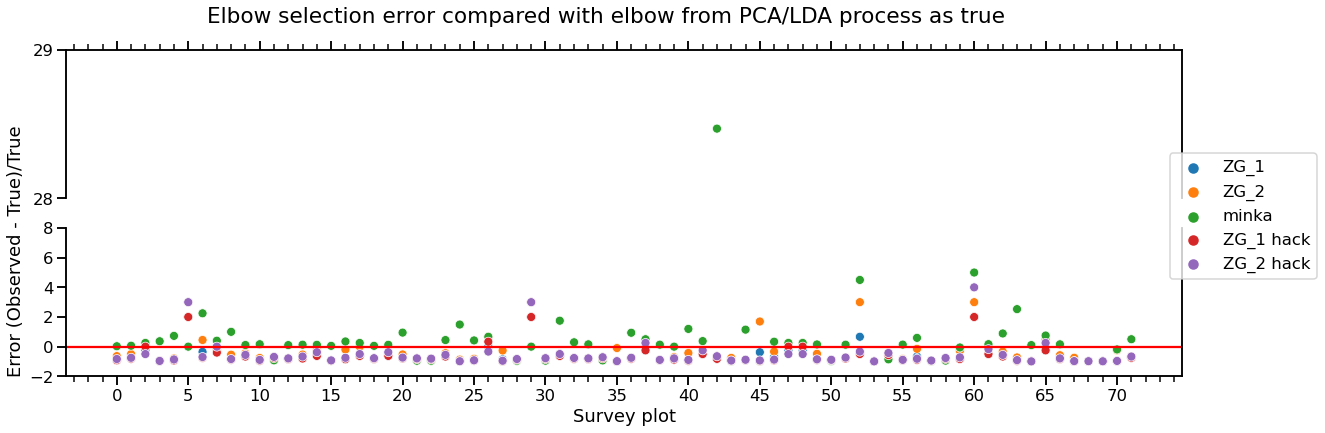

In [26]:
import seaborn as sns
import matplotlib.ticker as ticker
context="talk"
font_scale=1
with sns.plotting_context(context=context, font_scale=font_scale):
    # fig, axes = plt.subplots(1, 1)
    pca_lda_hist = []
    f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
    for i in range(len(all_miss)):
        es = [(np.median(dims_ZG_1_all[i]) - true_LDA[i] + 1)/(true_LDA[i] + 1), 
              (np.median(dims_ZG_2_all[i]) - true_LDA[i] + 1)/(true_LDA[i] + 1),  
              (np.median(dims_minka_all[i]) - true_LDA[i] + 1)/ (true_LDA[i] + 1), 
              (np.median(dims_ZG_h_1_all[i]) - true_LDA[i] + 1)/(true_LDA[i] + 1), 
              (np.median(dims_ZG_h_2_all[i]) - true_LDA[i] + 1) /(true_LDA[i] + 1)]
        xs = [i]*5    
        sns.scatterplot(x = xs, y = es, hue = ["ZG_1", "ZG_2", "minka" , "ZG_1 hack", "ZG_2 hack"], ax=ax)
        sns.scatterplot(x = xs, y = es, hue = ["ZG_1", "ZG_2", "minka" , "ZG_1 hack", "ZG_2 hack"], ax=ax2)
        pca_lda_hist.append(es)

    ax.set_ylim(28, 29)  # outliers only
    ax2.set_ylim(-2, 8)  # most of the data
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()
    ax2.set_xticks(np.arange(len(all_miss)))  
    ax.set_yticks([28, 29])  
    handles, labels = ax.get_legend_handles_labels()
    ax.legend().remove()
    ax2.legend().remove()
    f.legend(handles[:5], labels[:5], loc="center right")
    f.suptitle("Elbow selection error compared with elbow from PCA/LDA process as true")
    f.set_size_inches(20, 6)
    
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax2.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax2.set_ylabel("Error (Observed - True)/True", loc = 'bottom')
    plt.xlabel("Survey plot")
    plt.axhline(y=0, color='r', linestyle='-')
    f.show()

A histogram of all the errors per dimension selection techique is produced below

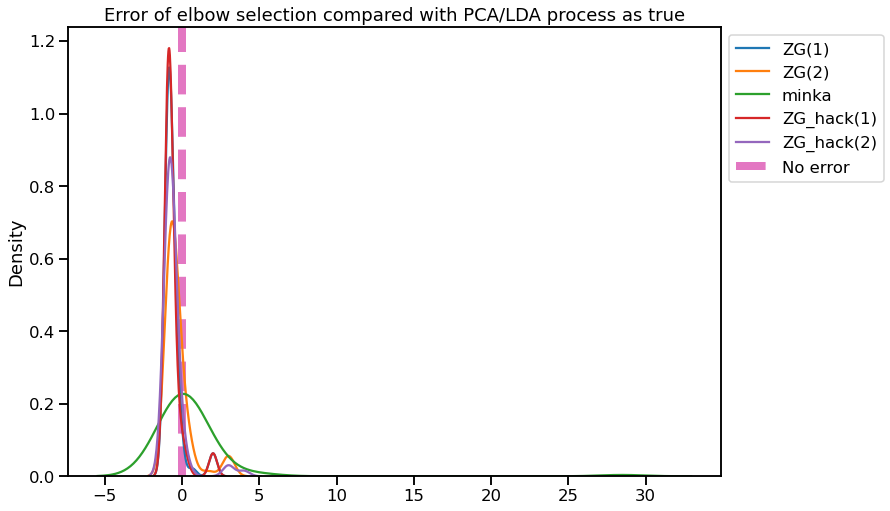

In [17]:
pca_lda_hist = np.asarray(pca_lda_hist)
with sns.plotting_context(context=context, font_scale=font_scale):
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    labs = ['ZG(1)', 'ZG(2)', 'minka', 'ZG_hack(1)', 'ZG_hack(2)']
    colors = sns.color_palette()
    for i in range(pca_lda_hist.shape[1]):
        sns.kdeplot(pca_lda_hist[:, i], ax=ax, label = labs[i] )

    plt.axvline(0, label='No error', color=colors[6], linewidth = 8, alpha = 1, zorder =  0, ls= "--")
    plt.title('Error of elbow selection compared with PCA/LDA process as true')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left',)
    plt.show()

## With survey estimate as true
A scatter plot of all the errors per dataset is produced below. please note this is only good for the first 46 datasets

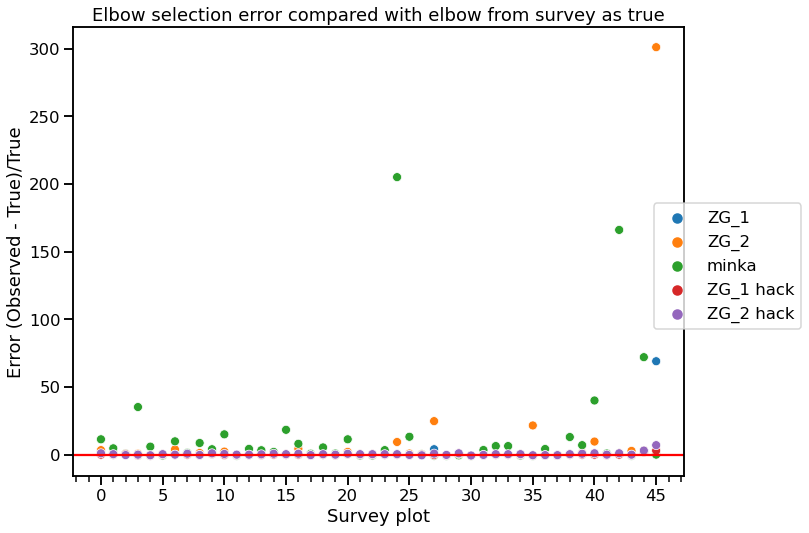

In [29]:
import seaborn as sns
import matplotlib.ticker as ticker


with sns.plotting_context(context=context, font_scale=font_scale):
    fig, axes = plt.subplots(1, 1)
    pca_surv_hist = []
    for i in range(len(true_survey)):
        es = [(np.median(dims_ZG_1_all[i]) - true_survey[i] + 1)/(true_survey[i] + 1), 
              (np.median(dims_ZG_2_all[i]) - true_survey[i] + 1)/(true_survey[i] + 1),  
              (np.median(dims_minka_all[i]) - true_survey[i] + 1)/ (true_survey[i] + 1), 
              (np.median(dims_ZG_h_1_all[i]) - true_survey[i] + 1)/(true_survey[i] + 1), 
              (np.median(dims_ZG_h_2_all[i]) - true_survey[i] + 1) /(true_survey[i] + 1)]
        xs = [i]*5    
        sns.scatterplot(x = xs, y = es, hue = ["ZG_1", "ZG_2", "minka" , "ZG_1 hack", "ZG_2 hack"])
        pca_surv_hist.append(es)
    axes.set_xticks(np.arange(len(true_survey)))  
    handles, labels = axes.get_legend_handles_labels()
    axes.legend().remove()
    fig.legend(handles[:5], labels[:5], loc='center right')

    fig.set_size_inches(11.7, 8.27)
    fig.show()
    plt.title("Elbow selection error compared with elbow from survey as true")
    axes.set_ylabel("Error (Observed - True)/True")
    axes.set_xlabel("Survey plot")
    axes.xaxis.set_major_locator(ticker.MultipleLocator(5))
    axes.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    # axes.set_xticklabels(labels = np.arange(46), rotation = (45), fontsize = 10, va='bottom', ha='left')
    plt.axhline(y=0, color='r', linestyle='-')
    fig.subplots_adjust(right=0.85)

A histogram of all the errors per dimension selection techique is produced below

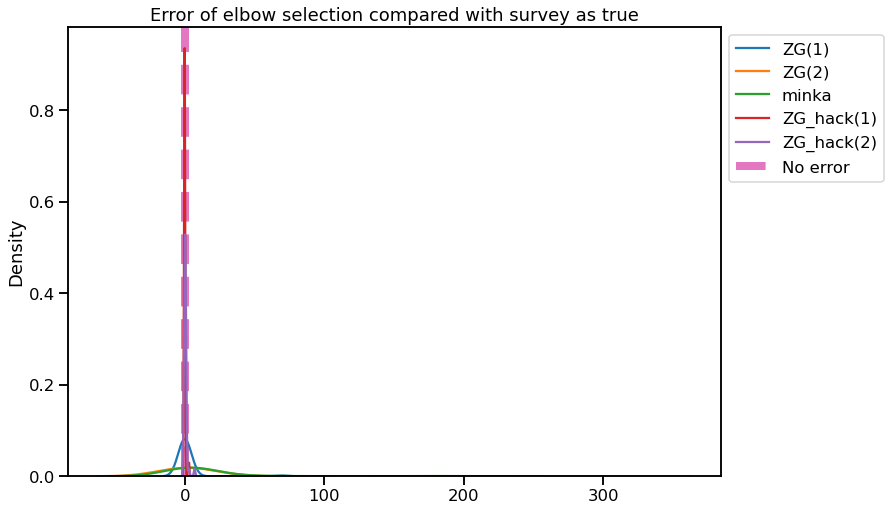

In [19]:
pca_surv_hist = np.asarray(pca_surv_hist)
with sns.plotting_context(context=context, font_scale=font_scale):
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    labs = ['ZG(1)', 'ZG(2)', 'minka', 'ZG_hack(1)', 'ZG_hack(2)']
    colors = sns.color_palette()
    for i in range(pca_surv_hist.shape[1]):
        sns.kdeplot(pca_surv_hist[:, i], ax=ax, label = labs[i] )

    plt.axvline(0, label='No error', color=colors[6], linewidth = 8, alpha = 1, zorder =  0, ls= "--")
    plt.title('Error of elbow selection compared with survey as true')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left',)
    plt.show()